# 数据下载和显示

自动下载因为网络原因已经跳过，手动从github处下载file后存放至对应位置

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

显示

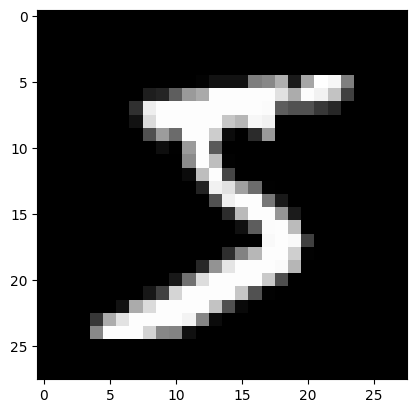

(50000, 784)


In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

用pytorch支持的格式显示

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# 手动搭建的神经网络

先初始化权重

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_() #希望上一步没有梯度
bias = torch.zeros(10, requires_grad=True)

定义softmax函数和神经网络模型（一个全连接层+Softmax）

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)# @用于表示矩阵相乘

In [7]:
bs = 64  # 批次

xb = x_train[0:bs]  #取一个批次
preds = model(xb)  # 预测（前向传播）
print(preds[0], preds.shape)

tensor([-2.6041, -1.5023, -2.3231, -2.4296, -2.4909, -2.1677, -2.1133, -2.5920,
        -2.9239, -2.6498], grad_fn=<SelectBackward0>) torch.Size([64, 10])


定义损失函数

In [8]:
def nll(input, target): #损失函数
    return -input[range(target.shape[0]), target].mean() #功能是计算每个样本的损失

loss_func = nll

yb = y_train[0:bs] 
print(loss_func(preds, yb)) # 计算损失

tensor(2.3191, grad_fn=<NegBackward0>)


定义准确率检测函数

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

def accuracy(out, yb): #计算准确率
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(2.3191, grad_fn=<NegBackward0>)
tensor(0.1250)


上述验证表明模型要素齐全，下面开始训练

In [10]:
# from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 1  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs #确定一批样本
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb) #正向传播
        loss = loss_func(pred, yb) #计算损失

        loss.backward() #反向传播
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [11]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb)) # 计算损失

tensor(0.1106, grad_fn=<NegBackward0>) tensor(1.)


# 使用torch.nn进行优化

上面跑完了完整的流程，之后用torch.nn中的部分函数对替换功能，使其更加简单。

可以用nn.functional替换自己写的损失函数

In [12]:
import torch.nn.functional as F

loss_func = F.cross_entropy #使用functional中自带的交叉熵函数

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.1106, grad_fn=<NllLossBackward0>) tensor(1.)


使用nn.Module对模型进行更简洁的描述（此处Module的M大写以便与python中module做区分）

In [13]:
from torch import nn

class Mnist_Logistic(nn.Module): #建立用于MNIST的模型
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784)) 
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2613, grad_fn=<NllLossBackward0>)


使用Module类中的函数进行梯度下降，并将其封装成一个函数

In [14]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs 
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb) #前向传播
            loss = loss_func(pred, yb) #计算损失

            loss.backward() #反向传播计算梯度
            with torch.no_grad():
                for p in model.parameters(): #对p中每个参数在梯度方向下降lr
                    p -= p.grad * lr
                model.zero_grad() #清除梯度

fit()

检测一下结果

In [15]:
print(loss_func(model(xb), yb),accuracy(model(xb), yb))

tensor(0.1051, grad_fn=<NllLossBackward0>) tensor(1.)


### 使用线性模型重构

上面使用了nn.functional和nn.Module对损失函数和模型训练方式进行了重构，但是还是需要手动确定权重和偏差，下面用线性模型替代了手动定义的Module

In [16]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10) #此处用线性模型替换原先的手动权重和偏差

    def forward(self, xb):
        return self.lin(xb)

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb),accuracy(model(xb),yb))

tensor(2.3340, grad_fn=<NllLossBackward0>)
tensor(0.1157, grad_fn=<NllLossBackward0>) tensor(1.)


### 优化器重构

使用optim来对所有的参数进行权重更新，并且可以使用更好的算法进行梯度下降

In [17]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr) #返回模型和优化器

model, opt = get_model()
print(loss_func(model(xb), yb)) #计算损失

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb),accuracy(model(xb), yb))

tensor(2.3047, grad_fn=<NllLossBackward0>)
tensor(0.1094, grad_fn=<NllLossBackward0>) tensor(1.)


### 用Dataset重构

使用Pytorch内建的数据集类对数据进行重构，这样可以更方便的同时访问输入和输出

In [18]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)#组合到一起

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs] #取出一个批次
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1087, grad_fn=<NllLossBackward0>)


### 用dataloader进行重构

pytorch中的dataloader能自动管理批次，这样便不用再进行手动的批次管理。

In [19]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs) #定义一个数据加载器，确定批次大小

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl: #相当于一个迭代器，可以自动给出大小为bs的批次
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb),accuracy(model(xb), yb))



tensor(0.1106, grad_fn=<NllLossBackward0>) tensor(1.)


### 增加验证集

先前的循环中，判断正确率使用的为训练集，而实际上应该有一个验证集来判断数据是否存在过拟合问题，由于验证集不需要梯度下降，验证集的大小可以设置为训练集的2倍。

此处出现了`model.train()`和`model.eval()`，用于标记不同的过程，以便在不同的过程中，使用不同的处理方式（通常是和正则化、归一化相关的操作，此处似乎无影响）

In [23]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

epochs = 2
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3625)
1 tensor(0.3048)


### 重构loss函数后的最终完整代码

由于训练集和测试集均需要计算损失，对损失函数进行重新封装，将最终重构后的完整代码放到下面

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10) #线性模型，输入784维，输出10维

    def forward(self, xb):
        return self.lin(xb)#前向传播（计算结果）

loss_func = F.cross_entropy #损失函数

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr) #返回模型和优化器


def loss_batch(model, loss_func, xb, yb, opt=None): #对批次计算损失和更改权重
    loss = loss_func(model(xb), yb)

    if opt is not None: 
        loss.backward()#反向传播
        opt.step()     #沿梯度方向更新权重
        opt.zero_grad()# 梯度清零

    return loss.item(), len(xb) #返回损失和样本数


def fit(epochs, model, loss_func, opt, train_dl, valid_dl): #训练函数
    for epoch in range(epochs): #训练次数
        model.train() #设置为训练模式
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt) #对批次进行训练

        model.eval() #设置为评估模式
        with torch.no_grad(): 
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]  #此处opt=None，便是只计算损失，不修改梯度
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

bs=64
epochs=3
train_ds = TensorDataset(x_train, y_train) #用tensordataset组合数据：训练集
valid_ds = TensorDataset(x_valid, y_valid) #用tensordataset组合数据：验证集
train_dl, valid_dl = get_data(train_ds, valid_ds, bs) #用dataloader进行批次的管理，不用手动指定批次
model, opt = get_model() #获取模型和
fit(epochs, model, loss_func, opt, train_dl, valid_dl) #训练

0 0.3327121156334877
1 0.31077337105870245
2 0.3096354569196701


# 转为CNN网络

现在使用一个CNN的网络模型来进行处理

In [26]:
class Mnist_CNN(nn.Module): #CNN网络
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  #卷积层1，卷积核3x3，步长2，填充1，输出16个通道
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1) #卷积层2，卷积核3x3，步长2，填充1，输出16个通道
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1) #卷积层3，卷积核3x3，步长2，填充1，输出10个通道

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) #类似于reshape，这里-1标识图片数量自动调整，1为一个通道（只有黑白），然后是二维图片大小(28x28)
        xb = F.relu(self.conv1(xb)) # 对每次卷积后的结果通过ReLU函数处理
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)    #最终卷积的结果为10个通道的4x4图像，进行平均池化
        return xb.view(-1, xb.size(1)) #调整为2维，第一维是图片数量

lr = 0.1

In [27]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.32165791087150575
1 0.24066495181322098
2 0.18938506301045419


### 使用Sequential重构

可以通过更为简单的方式构建模型，即nn.Sequential来定义网络结构。

In [28]:
class Lambda(nn.Module): #相当于定义一种通用lambda函数
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x): #数据预处理的函数
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), #三层卷积和三个ReLU
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4), #平均池化
    Lambda(lambda x: x.view(x.size(0), -1)), #全连接
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9) #使用动量的梯度下降

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3192536866664886
1 0.21486380007266997
2 0.22305934345722198


### 包装数据加载器

包装数据加载器使其能够更加通用

In [29]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [30]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4255438080072403
1 0.2736359963655472
2 0.21468227762579917


### 用GPU运算

In [31]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)    #需要搬运数据到GPU之中


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20255440651774406
1 0.20829519386291503
2 0.1576838986635208


### 对于CNN的完整网络

把上面所有的重构整合一下，并使用GPU运算，如下所示

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn

class WrappedDataLoader: #定义一种数据加载器的封装（可使用func进行预处理）
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

def preprocess(x,y): #数据预处理的函数
    return x.view(-1, 1, 28, 28).to(dev),y.to(dev)


def loss_batch(model, loss_func, xb, yb, opt=None): #对批次计算损失和更改权重
    loss = loss_func(model(xb), yb)

    if opt is not None: 
        loss.backward()#反向传播
        opt.step()     #沿梯度方向更新权重
        opt.zero_grad()# 梯度清零

    return loss.item(), len(xb) #返回损失和样本数


def fit(epochs, model, loss_func, opt, train_dl, valid_dl): #训练函数
    for epoch in range(epochs): #训练次数
        model.train() #设置为训练模式
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt) #对批次进行训练

        model.eval() #设置为评估模式
        with torch.no_grad(): 
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]  #此处opt=None，便是只计算损失，不修改梯度
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

bs=64
epochs=3
train_ds = TensorDataset(x_train, y_train) #用tensordataset组合数据：训练集
valid_ds = TensorDataset(x_valid, y_valid) #用tensordataset组合数据：验证集
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)
loss_func = F.cross_entropy #损失函数
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), #三层卷积和三个ReLU
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4), #平均池化
    Lambda(lambda x: x.view(x.size(0), -1)), #全连接
)
model.to(dev)
fit(epochs, model, loss_func, opt, train_dl, valid_dl) #训练

0 2.301221157836914
1 2.301221157836914
2 2.301221157836914
